In [1]:
import bagpy
from bagpy import bagreader

# This block read in the bag file and save it as a csv file.
# I didn't upload the bag file to github because it's too large.
# The csv can be read in the next block.
b = bagreader('_2024-04-22-20-38-27_0.bag')

LASER_MSG = b.message_by_topic('/digit_state')
LASER_MSG

[INFO]  Successfully created the data folder _2024-04-22-20-38-27_0.


'_2024-04-22-20-38-27_0/digit_state.csv'

In [2]:
import scipy
import numpy as np
import pandas as pd
digit_state_all = pd.read_csv('_2024-04-22-20-38-27_0/digit_state.csv')

time_period = range(0,60000)
position_full = digit_state_all.loc[time_period, 'position_full_0':'position_full_29']
velocity_full = digit_state_all.loc[time_period,'velocity_full_0':'velocity_full_29']
torque = digit_state_all.loc[time_period,'torque_0':'torque_19']
base_position = digit_state_all.loc[time_period,'base_position_0':'base_position_2']
base_velocity = digit_state_all.loc[time_period,'base_velocity_0':'base_velocity_2']

# Generate csv that's not down sampled.
pd.concat([position_full, velocity_full, torque, base_position, base_velocity], axis=1).to_csv('digit_state_20240514.csv', index=False)


In [5]:
base_position_bak = base_position.copy()

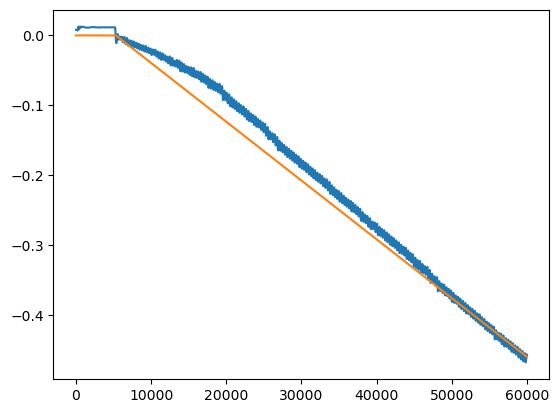

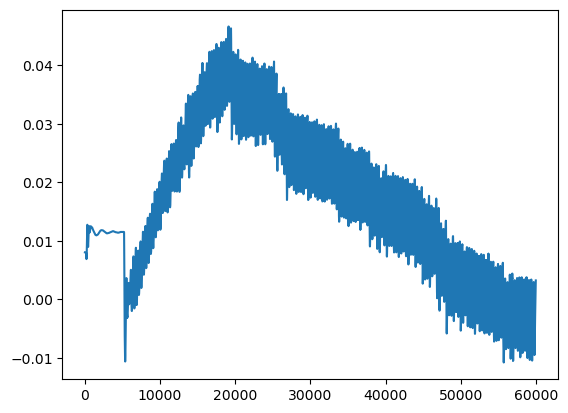

In [32]:
import matplotlib.pyplot as plt
base_position = base_position_bak.copy()
# base_position['base_position_2'].plot()
time_period = range(0,60000)
plt.plot(base_position.loc[time_period, 'base_position_2'])

# Manual set compensate
z_compensate = np.zeros(60000)
z_compensate[5300:] = np.linspace(0, -0.46, 60000-5300)
plt.plot(z_compensate)
plt.show()

base_position['base_position_2'] = base_position['base_position_2'] - z_compensate
plt.plot(base_position.loc[time_period, 'base_position_2'])

pd.concat([position_full, velocity_full, torque, base_position, base_velocity], axis=1).to_csv('digit_state_20240514.csv', index=False)

In [4]:
import scipy
import numpy as np
import pandas as pd
digit_state_all = pd.read_csv('digit_state.csv')

# This part of the trajectory is stable walking. The sample rate is 1000Hz.
time_period = range(15000,25000)
position_full = digit_state_all.loc[time_period, 'position_full_0':'position_full_29']
# Generate a function that can be used to interpolate at any index.
f = scipy.interpolate.interp1d(np.arange(15000,25000), position_full.to_numpy(), axis=0)
# position_downsample = f(np.arange(15000,25000,2.5))
position_downsample = pd.DataFrame(f(np.arange(15000,25000,2.5)), columns = position_full.keys()) # Downsample the trajectory from 1000Hz to 400Hz. 2.5 = 1000/400.

velocity_full = digit_state_all.loc[time_period,'velocity_full_0':'velocity_full_29']
f = scipy.interpolate.interp1d(np.arange(15000,25000), velocity_full.to_numpy(), axis=0)
velocity_downsample = pd.DataFrame(f(np.arange(15000,25000,2.5)), columns = velocity_full.keys())

torque = digit_state_all.loc[time_period,'torque_0':'torque_19']
f = scipy.interpolate.interp1d(np.arange(15000,25000), torque.to_numpy(), axis=0)
torque_downsample = pd.DataFrame(f(np.arange(15000,25000,2.5)), columns = torque.keys())

base_position = digit_state_all.loc[time_period,'base_position_0':'base_position_2']
f = scipy.interpolate.interp1d(np.arange(15000,25000), base_position.to_numpy(), axis=0)
base_position_downsample = pd.DataFrame(f(np.arange(15000,25000,2.5)), columns = base_position.keys())

base_velocity = digit_state_all.loc[time_period,'base_velocity_0':'base_velocity_2']
f = scipy.interpolate.interp1d(np.arange(15000,25000), base_velocity.to_numpy(), axis=0)
base_velocity_downsample = pd.DataFrame(f(np.arange(15000,25000,2.5)), columns = base_velocity.keys())

pd.concat([position_downsample, velocity_downsample, torque_downsample, base_position_downsample, base_velocity_downsample], axis=1).to_csv('digit_state_downsample.csv', index=False)

In [7]:
base_velocity_downsample

,base_velocity_0,base_velocity_1,base_velocity_2
0,0.401387,0.270018,-0.122184
1,0.397844,0.268236,-0.139806
2,0.396368,0.267138,-0.156198
3,0.397141,0.266163,-0.170310
4,0.399272,0.265084,-0.181452
...,...,...,...
3995,0.361682,-0.159001,0.002152
3996,0.360979,-0.154925,0.004915
3997,0.360215,-0.150758,0.007606
3998,0.359443,-0.146674,0.010107


In [8]:
import pandas as pd

# Read in all the recorded data and extract the position, velocity, and torque.
# Use this block to form a reward in Digit's gym environment.
digit_state_distill = pd.read_csv('digit_state_downsample.csv')

# The definition of position_full and velocity_full is in digit_main. 
# https://github.gatech.edu/GeorgiaTechLIDARGroup/digit_main/blob/d11392ff2c08593005b2d5e0187e3e9c0fd84f49/include/digit_definition.hpp#L17
position_full = digit_state_distill.loc[:,'position_full_0':'position_full_29']

velocity_full = digit_state_distill.loc[:,'velocity_full_0':'velocity_full_29']

# The definition of motor torque is also in digit_main.
# https://github.gatech.edu/GeorgiaTechLIDARGroup/digit_main/blob/d11392ff2c08593005b2d5e0187e3e9c0fd84f49/include/digit_definition.hpp#L100
torque = digit_state_distill.loc[:,'torque_0':'torque_19']

base_position = digit_state_all.loc[time_period,'base_position_0':'base_position_2']

base_velocity = digit_state_all.loc[time_period,'base_velocity_0':'base_velocity_2']

torque.shape


(4000, 20)

In [ ]:
# Testing module.
print(position_downsample.shape)
print(position_downsample.head())
import numpy as np
import scipy
import matplotlib.pyplot as plt
index = np.arange(0,10.,2.5)
print(index)
# f = scipy.interpolate.interp1d(np.arange(0,10), position_full.to_numpy(), axis=0)
# y = f(index)
# position_downsample = position_full.to_numpy()
# print(position_downsample)
# plt.plot(index, y)
# print(y)
torque.keys()
